## Downloading the dataset and importing it into our environment

In [1]:
import pandas as pd
import json

In [2]:
raw_data = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
raw_data.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [4]:
raw_data = raw_data.loc[:, ['title', 'genres', 'keywords']]
raw_data.head(5)

,title,genres,keywords
0,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":..."
1,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na..."
2,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name..."
3,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,..."
4,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."


In [5]:
# convert the relevant data for each movie into a single string
# to be ingested by TfidfVectorizer
def genres_and_keywords_to_string(row):
    # converting the genre and keywords columns into a single string
    genres = json.loads(row['genres'])
    genres = ' '.join(''.join(j['name'].split()) for j in genres)

    keywords = json.loads(row['keywords'])
    keywords = ' '.join(''.join(j['name'].split()) for j in keywords)
    return f"{genres} {keywords}"

In [6]:
# create a new string representation of each movie
raw_data['string'] = raw_data.apply(genres_and_keywords_to_string, axis=1)

In [7]:
raw_data.head(3)

,title,genres,keywords,string
0,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",Action Adventure Fantasy ScienceFiction cultur...
1,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",Adventure Fantasy Action ocean drugabuse exoti...
2,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",Action Adventure Crime spy basedonnovel secret...


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
# Instanciating our TFIDF class
tfidf = TfidfVectorizer()

In [10]:
# Create our target variable
X = tfidf.fit_transform(raw_data['string'])

In [11]:
X

<4803x9789 sparse matrix of type '<class 'numpy.float64'>'
	with 48763 stored elements in Compressed Sparse Row format>

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
query = X[0]
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [14]:
# Getting the cosine similarities between a vector and the rest
scores = cosine_similarity(query, X)
print(scores)

[[1.         0.02710478 0.02376538 ... 0.01134904 0.         0.        ]]


In [15]:
# Flattening the array to make it one dimensional
scores = scores.flatten()

In [16]:
import matplotlib.pyplot as plt

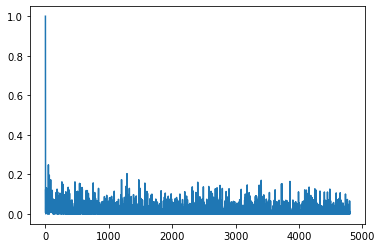

In [17]:
plt.plot(scores)

In [29]:
(-scores).argsort()

array([   0,   47, 1287, ..., 2570, 2574, 4802], dtype=int64)

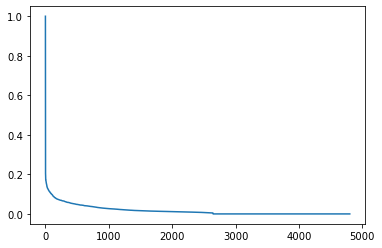

In [30]:
plt.plot(scores[(-scores).argsort()])

In [34]:
recommended_idx = (-scores).argsort()[1:6]
raw_data.title.iloc[recommended_idx]

47      Star Trek Into Darkness
1287         A Monster in Paris
61            Jupiter Ascending
1201                  Predators
1473       The Astronaut's Wife
Name: title, dtype: object

In [37]:
# Creating a function to run the whole process for us
def recommend(name):
    try:
        # Getting the index of the movie inserted into the function
        idx = raw_data[raw_data.title == name].index[0]
        idx
        #Getting the vector conversion of the movie
        query = X[idx].toarray()
        # Comparing the movie vector to other movies vectors
        scores = cosine_similarity(query, X)
        # Changing the dimension of the movie
        scores = scores.flatten()
        # Getting the index of the most similar movies while omitting the movie itself
        recommendationidx = (-scores).argsort()[1:10]
        # returning the name of the movies
        return raw_data.title[recommendationidx]
    except IndexError:
        # Handling movies that do not exist in the dataset
        print("This movie is not present in our database")
        print("No recommendation available")

In [39]:
print("Recommendations for 'Ice Age' : ")
print(recommend('Ice Age'))

Recommendations for 'Ice Age' : 
2787                                       Quest for Fire
2633                            The Clan of the Cave Bear
748                                              Year One
514                                 Ice Age: The Meltdown
234                                            The Croods
194                                              Dinosaur
1580                                          The Nut Job
1044                   Journey to the Center of the Earth
3403    Alpha and Omega: The Legend of the Saw Tooth Cave
Name: title, dtype: object


In [40]:
print("Recommendations for 'Robo' : ")
print(recommend('Robo'))

Recommendations for 'Robo' : 
This movie is not present in our database
No recommendation available
None
